# Set up
Import libraries

In [ ]:
import pandas as pd
import numpy as np
import json
import pickle
import os
import shutil #save images
from tqdm import tqdm #progress bar
import cv2
import matplotlib.pyplot as plt
import joblib

# K-fold Cross Validation
from sklearn.model_selection import GridSearchCV, GroupKFold

# classification
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.covariance import empirical_covariance, oas, graphical_lasso
from sklearn.utils import shuffle

# metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import ConfusionMatrixDisplay

##Mount google drive and GCS

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:

# Authenticate.
from google.colab import auth
auth.authenticate_user()

# Install Cloud Storage FUSE.
!echo "deb https://packages.cloud.google.com/apt gcsfuse-`lsb_release -c -s` main" | sudo tee /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -
!apt -qq update && apt -qq install gcsfuse

deb https://packages.cloud.google.com/apt gcsfuse-jammy main
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0Warning: apt-key is deprecated. Manage keyring files in trusted.gpg.d instead (see apt-key(8)).
100  1022  100  1022    0     0   5802      0 --:--:-- --:--:-- --:--:--  5806
OK
48 packages can be upgraded. Run 'apt list --upgradable' to see them.
W: https://packages.cloud.google.com/apt/dists/gcsfuse-jammy/InRelease: Key is stored in legacy trusted.gpg keyring (/etc/apt/trusted.gpg), see the DEPRECATION section in apt-key(8) for details.
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
The following NEW packages will be installed:
  gcsfuse
0 upgraded, 1 n

In [ ]:
# Mount a Cloud Storage bucket or location
mount_path = "281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518"
local_path = f"/mnt/gs/{mount_path}"

!mkdir -p {local_path}
!gcsfuse --implicit-dirs {mount_path} {local_path}

{"timestamp":{"seconds":1722670167,"nanos":641118059},"severity":"INFO","message":"Start gcsfuse/2.4.0 (Go version go1.22.4) for app \"\" using mount point: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518\n"}
{"timestamp":{"seconds":1722670167,"nanos":641375706},"severity":"INFO","message":"GCSFuse mount command flags: {\"AppName\":\"\",\"Foreground\":false,\"ConfigFile\":\"\",\"MountOptions\":{},\"DirMode\":493,\"FileMode\":420,\"Uid\":-1,\"Gid\":-1,\"ImplicitDirs\":true,\"OnlyDir\":\"\",\"RenameDirLimit\":0,\"IgnoreInterrupts\":true,\"CustomEndpoint\":null,\"BillingProject\":\"\",\"KeyFile\":\"\",\"TokenUrl\":\"\",\"ReuseTokenFromUrl\":true,\"EgressBandwidthLimitBytesPerSecond\":-1,\"OpRateLimitHz\":-1,\"SequentialReadSizeMb\":200,\"AnonymousAccess\":false,\"MaxRetrySleep\":30000000000,\"MaxRetryAttempts\":0,\"StatCacheCapacity\":20460,\"StatCacheTTL\":60000000000,\"TypeCacheTTL\":60000000000,\"KernelListCacheTtlSeconds\":0,\"HttpClientTimeout\":0,\"RetryMultiplier\":2,\"Tem

In [ ]:
input_path = os.path.join(local_path, 'feature_matrices')

#test mounting
os.listdir(input_path)

['test_features_matrix.pkl',
 'test_label.pkl',
 'train_features_matrix.pkl',
 'train_label.pkl',
 'val_features_matrix.pkl',
 'validation_label.pkl']

## Load Train and Validation Features

In [ ]:
def load_image_labels(input_path):
    train_lb = pickle.load(open(input_path + '/' + 'train_label'  + '.pkl', 'rb'))
    val_lb = pickle.load(open(input_path + '/' + 'validation_label' + '.pkl', 'rb'))
    test_lb = pickle.load(open(input_path + '/' + 'test_label' + '.pkl', 'rb'))

    return train_lb, val_lb, test_lb

In [ ]:
#load the labels from file in drive
df_train_label = load_image_labels(input_path)[0]
df_val_label = load_image_labels(input_path)[1]
df_test_label = load_image_labels(input_path)[2]


## Load Train and Validation Features

In [ ]:
def load_features(feature_path, feature):
    train_fm = pickle.load(open(feature_path + '/' +  'train_' + feature + '_std'  + '.pkl', 'rb'))
    val_fm = pickle.load(open(feature_path + '/' +  'validation_' + feature + '_std'  +'.pkl', 'rb'))
    test_fm = pickle.load(open(feature_path + '/' +  'test_' + feature + '_std'  + '.pkl', 'rb'))

    return train_fm, val_fm, test_fm

In [ ]:
feature_path = os.path.join(local_path, 'features')
os.listdir(f"{feature_path}/")

['kmeans_model.pkl',
 'test_cnn.pkl',
 'test_cnn_std.pkl',
 'test_hog.pkl',
 'test_hog_std.pkl',
 'test_sift.pkl',
 'test_sift_std.pkl',
 'test_sobel.pkl',
 'test_sobel_std.pkl',
 'tfidf_transformer.pkl',
 'train_cnn.pkl',
 'train_cnn_std.pkl',
 'train_hog.pkl',
 'train_hog_std.pkl',
 'train_sift.pkl',
 'train_sift_std.pkl',
 'train_sobel.pkl',
 'train_sobel_std.pkl',
 'validation_cnn.pkl',
 'validation_cnn_std.pkl',
 'validation_hog.pkl',
 'validation_hog_std.pkl',
 'validation_sift.pkl',
 'validation_sift_std.pkl',
 'validation_sobel.pkl',
 'validation_sobel_std.pkl']

In [ ]:
# loading feature vector for each set
x_train = load_features(feature_path,'sift')[0]
x_val = load_features(feature_path,'sift')[1]
x_test = load_features(feature_path,'sift')[2]

In [ ]:
# Convert to numpy arrays
x_train = np.array(list(x_train.values()))
x_val = np.array(list(x_val.values()))
x_test = np.array(list(x_test.values()))

In [ ]:
# get indices for feature matrices
train_fm_ind = pickle.load(open(local_path + '/features' + '/train_sift_std'  + '.pkl', 'rb'))
val_fm_ind = pickle.load(open(local_path + '/features' + '/validation_sift_std' + '.pkl', 'rb'))
test_fm_ind = pickle.load(open(local_path + '/features' + '/test_sift_std' + '.pkl', 'rb'))

In [ ]:
# create dataframe with image filename as the indices
df_train = pd.DataFrame({'sift': [pca_vector for pca_vector in x_train]}, index = list(train_fm_ind.keys()))
df_val = pd.DataFrame({'sift': [pca_vector for pca_vector in x_val]}, index = list(val_fm_ind.keys()))
df_test = pd.DataFrame({'sift': [pca_vector for pca_vector in x_test]}, index = list(test_fm_ind.keys()))

In [ ]:
# join feature dataframes with labels and groups on the indices
# puting df_{set}_label on the left to preserve suffled image orders
df_train = df_train_label.join(df_train, on=None, how='left', validate='one_to_one')
df_val = df_val_label.join(df_val, on=None, how='left', validate='one_to_one')
df_test = df_test_label.join(df_test, on=None, how='left', validate='one_to_one')

# Combine train and validation feature dataframes

In [ ]:
# combine train and val dataframes
df = pd.concat([df_train, df_val], axis=0)
df.head()


,label,group,sift
image,,,
N25_100EK113_03030540.JPG,Peccary,Peccary-398d85ab-7160-11ec-898c-5cf3706028c2,"[-0.7776168806203599, 0.21628323500796873, -0...."
N25_100EK113_03030542.JPG,Peccary,Peccary-398d85ab-7160-11ec-898c-5cf3706028c2,"[0.19333969217871602, -0.7776168806203599, 0.9..."
N25_100EK113_03030539.JPG,Peccary,Peccary-398d85ab-7160-11ec-898c-5cf3706028c2,"[-0.7776168806203599, -0.7776168806203599, 0.6..."
N25_100EK113_03030541.JPG,Peccary,Peccary-398d85ab-7160-11ec-898c-5cf3706028c2,"[0.06181457238584834, 0.27445884524090364, 0.7..."
N25_100EK113_03030538.JPG,Peccary,Peccary-398d85ab-7160-11ec-898c-5cf3706028c2,"[0.0017878383703323945, -0.7776168806203599, 0..."


# Grouped K-Fold Cross Validation

In [ ]:
# X, y, and groups are your data and group labels
# specify feature columns
X = np.vstack(df['sift'].to_numpy())
# label coluns
y = df['label']
# read group from labels
groups =  df['group']
# specify splits
splits = 5
# path storing outputs
output_path = os.path.join(local_path, 'weights')
os.makedirs(output_path, exist_ok=True)


In [ ]:
# # Train model
# model = LinearDiscriminantAnalysis()

# # parameter grid
# param_grid = [{
#     'solver': ['svd'],
#     'shrinkage': [None],
#     'priors': [None],
#     'n_components': [None, 1, 2, 3, 4, 5],
#     'store_covariance': [False, True],
#     'tol': [1e-4, 1e-5, 1e-6],
#     'covariance_estimator': [None]
#     },
#               {
#     'solver': ['lsqr'],
#     'shrinkage': ['auto', 0.2, 0.4, 0.6, 0.8],
#     'priors': [None],
#     'n_components': [None, 1, 2, 3, 4, 5],
#     'store_covariance': [False],
#     'covariance_estimator': [None]
#     },
#               {
#     'solver': ['eigen'],
#     'shrinkage': ['auto', 0.2, 0.4, 0.6, 0.8],
#     'priors': [None],
#     'n_components': [None, 1, 2, 3, 4, 5],
#     'store_covariance': [False],
#     'covariance_estimator': [None]
#     }
# ]

# #shuffle data, using random state = 281
# X, y, groups = shuffle(X, y, groups, random_state=281)

# # grouped k-fold
# gkf = GroupKFold(n_splits=splits)

# grid_search = GridSearchCV(estimator=model,
#                            param_grid=param_grid,
#                            cv=gkf,
#                            scoring='accuracy',
#                            verbose=2,
#                            n_jobs=1,
#                            return_train_score=True)



# # save intermediate steps in case colab gets disconnected
# intermediate_path = output_path + '/lda_sift_grid_search_intermediate.pkl'

# # Check if intermediate results exist
# if os.path.exists(intermediate_path):
#     saved_state = joblib.load(intermediate_path)
#     grid_search = saved_state['grid_search']
#     last_iteration = saved_state['last_iteration']
#     print(f"Resuming grid search from iteration {last_iteration}.")
# else:
#     last_iteration = 0
#     print("Starting new grid search.")

# with tqdm(total=len([i['solver'] for i in param_grid]) * len([i['shrinkage'] for i in param_grid]) * len([i['n_components'] for i in param_grid]), desc="Grid Search") as pbar:
#     def callback(*args, **kwargs):
#         pbar.update(1)
#         # Save intermediate results every 5 updates
#         if pbar.n % 5 == 0:
#             joblib.dump({'grid_search': grid_search, 'last_iteration': pbar.n}, intermediate_path)

#     # Monkey patch the fit method to include the callback
#     original_fit = grid_search.fit
#     def fit_with_callback(*args, **kwargs):
#         original_fit(*args, **kwargs)
#         callback()

#     grid_search.fit = fit_with_callback

#     # Fit the model
#     grid_search.fit(X, y, groups=groups)

# best_params = grid_search.best_params_
# print("Best parameters found: ", best_params)

# best_score = grid_search.best_score_
# print("Best score found: ", best_score)

# train_score = grid_search.cv_results_
# print("train score: ", train_score.keys())

# # Save the final best model
# lda_best_model = grid_search.best_estimator_
# pickle.dump(lda_best_model, open(output_path + '/lda_sift_best_model.pkl', 'wb'))

# # Save the final grid search results
# joblib.dump(grid_search, output_path + '/lda_sift_grid_search_final.pkl')

# # Save the train scores
# pickle.dump(train_score, open(output_path + '/lda_sift_train_score.pkl', 'wb'))

Starting new grid search.


Grid Search:   0%|          | 0/27 [00:00<?, ?it/s]

Fitting 5 folds for each of 96 candidates, totalling 480 fits
[CV] END covariance_estimator=None, n_components=None, priors=None, shrinkage=None, solver=svd, store_covariance=False, tol=0.0001; total time=   0.1s
[CV] END covariance_estimator=None, n_components=None, priors=None, shrinkage=None, solver=svd, store_covariance=False, tol=0.0001; total time=   0.1s
[CV] END covariance_estimator=None, n_components=None, priors=None, shrinkage=None, solver=svd, store_covariance=False, tol=0.0001; total time=   0.2s
[CV] END covariance_estimator=None, n_components=None, priors=None, shrinkage=None, solver=svd, store_covariance=False, tol=0.0001; total time=   0.2s
[CV] END covariance_estimator=None, n_components=None, priors=None, shrinkage=None, solver=svd, store_covariance=False, tol=0.0001; total time=   0.2s
[CV] END covariance_estimator=None, n_components=None, priors=None, shrinkage=None, solver=svd, store_covariance=False, tol=1e-05; total time=   0.2s
[CV] END covariance_estimator=Non

Grid Search:   4%|▎         | 1/27 [01:24<36:24, 84.02s/it]


Best parameters found:  {'covariance_estimator': None, 'n_components': None, 'priors': None, 'shrinkage': None, 'solver': 'svd', 'store_covariance': False, 'tol': 0.0001}
Best score found:  0.4715185444366689
train score:  dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_covariance_estimator', 'param_n_components', 'param_priors', 'param_shrinkage', 'param_solver', 'param_store_covariance', 'param_tol', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'mean_train_score', 'std_train_score'])


In [ ]:
# load best-performing model from grid search
# {'covariance_estimator': None, 'n_components': None, 'priors': None, 'shrinkage': None, 'solver': 'svd', 'store_covariance': False, 'tol': 0.0001}
output_path = os.path.join(local_path, 'weights')
best_model = pickle.load(open(output_path + '/lda_sift_best_model.pkl', 'rb'))

# plot confusion matrix
y_pred = best_model.predict(X)
cm = confusion_matrix(y, y_pred)

In [ ]:
# load training scores
train_score = pickle.load(open(output_path + '/lda_sift_train_score.pkl', 'rb'))

# Model Evaluation
- Train set + validation set

In [ ]:
# Get Predictions for test set

X_test = np.vstack(df_test['sift'].to_numpy())
# label coluns
y_test = df_test['label']
# read group from labels
groups_test =  df_test['group']

In [ ]:
# test set prediction and accuracy for best model
y_pred_test = best_model.predict(X_test)

In [ ]:
print('Accuracy Score: ', accuracy_score(y_test, y_pred_test))
print('F1 Score: ', f1_score(y_test, y_pred_test, average=None))


Accuracy Score:  0.44537346711259757
F1 Score:  [0.42190016 0.40071556 0.51622875 0.31849315 0.4375     0.55924171]


## Confisuion Matrix for Train Set

Best-performing model: LDA SVD with tol=0.0001


<Figure size 1500x1500 with 0 Axes>

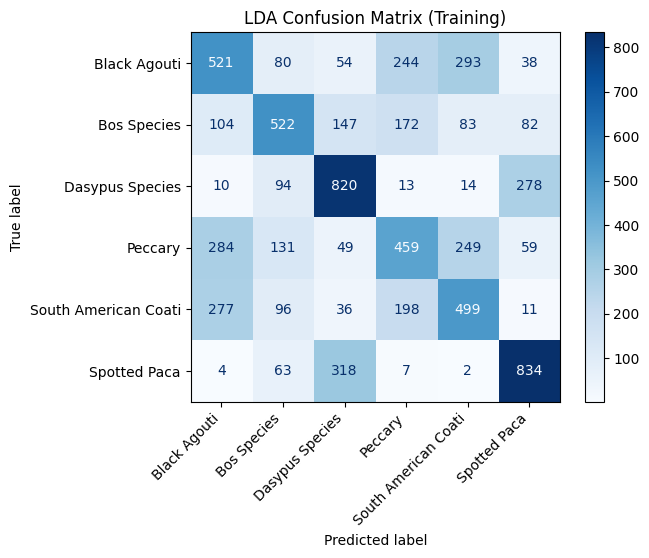

In [ ]:
# visualize confusion matrix
# Confusion matrix
print('Best-performing model: LDA SVD with tol=0.0001')
cm = confusion_matrix(y, y_pred)
label_names = best_model.classes_
plt.figure(figsize=(15, 15))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=45, ha='right')
plt.title('LDA Confusion Matrix (Training)')
plt.show()

<Figure size 1500x1500 with 0 Axes>

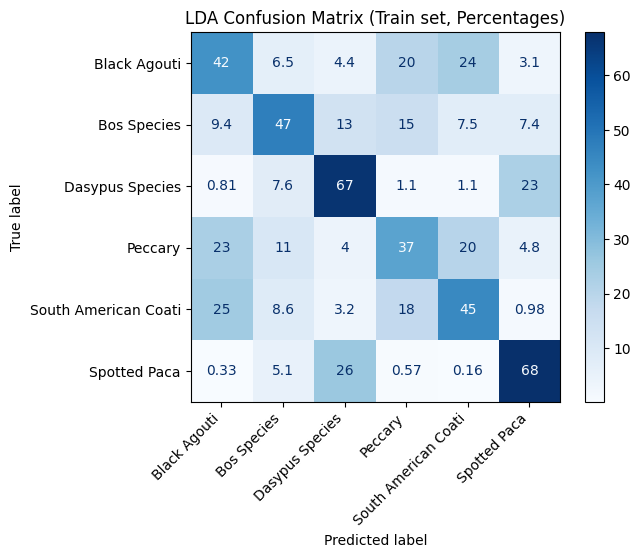

Best-performing model: LDA SVD with tol=0.0001. Average values over K = 5 folds


In [ ]:
# Confusion Matrix (Percentage)

cm = confusion_matrix(y, y_pred)

# Normalize the confusion matrix by the number of true instances in each class
cm_normalized = np.round((cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]) * 100, decimals=4)

label_names = best_model.classes_
plt.figure(figsize=(15, 15))
disp = ConfusionMatrixDisplay(confusion_matrix= cm_normalized, display_labels=label_names)
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=45, ha='right')
plt.title('LDA Confusion Matrix (Train set, Percentages)')
plt.show()
print('Best-performing model: LDA SVD with tol=0.0001. Average values over K = 5 folds')

## Confusion Matrix for Test Set

Best-performing model: LDA SVD with tol=0.0001


<Figure size 1500x1500 with 0 Axes>

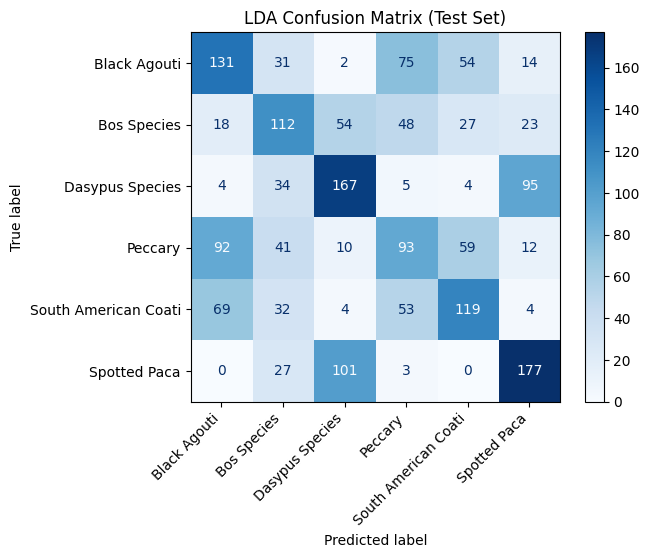

In [ ]:
# visualize confusion matrix
# Confusion matrix
print('Best-performing model: LDA SVD with tol=0.0001')
cm = confusion_matrix(y_test, y_pred_test)
label_names = best_model.classes_
plt.figure(figsize=(15, 15))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=45, ha='right')
plt.title('LDA Confusion Matrix (Test Set)')
plt.show()

<Figure size 1500x1500 with 0 Axes>

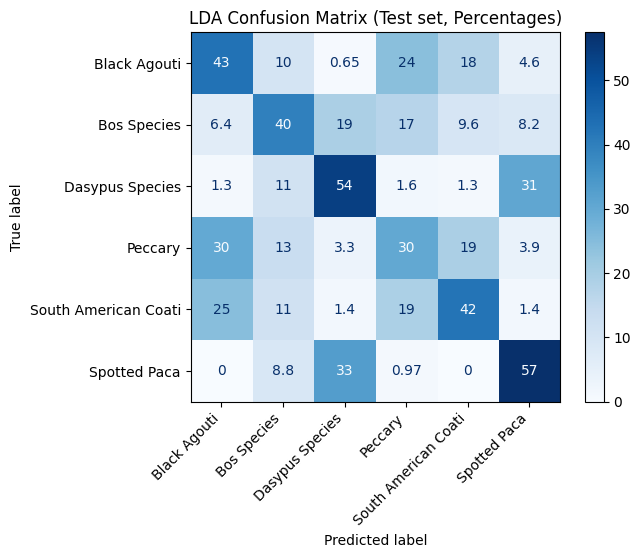

Best-performing model: LDA SVD with tol=0.0001. Average values over K = 5 folds


In [ ]:
# Confusion Matrix (Percentage)

cm = confusion_matrix(y_test, y_pred_test)

# Normalize the confusion matrix by the number of true instances in each class
cm_normalized = np.round((cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]) * 100, decimals=3)

label_names = best_model.classes_
plt.figure(figsize=(15, 15))
disp = ConfusionMatrixDisplay(confusion_matrix= cm_normalized, display_labels=label_names)
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=45, ha='right')
plt.title('LDA Confusion Matrix (Test set, Percentages)')
plt.show()
print('Best-performing model: LDA SVD with tol=0.0001. Average values over K = 5 folds')

## ROC Curve

In [ ]:
from sklearn.preprocessing import LabelEncoder
# Encode Labels
# Creating labelEncoder
label_encoder = LabelEncoder()

# Assigning numerical values and storing in another column
label_encoder.fit_transform(y)


array([3, 3, 3, ..., 1, 1, 1])

In [ ]:
from sklearn.preprocessing import LabelBinarizer

label_binarizer = LabelBinarizer().fit(y)
y_onehot_train = label_binarizer.transform(y_test)
y_scores = best_model.fit(X, y).predict_proba(X_test)
y_onehot_train.shape


(1794, 6)

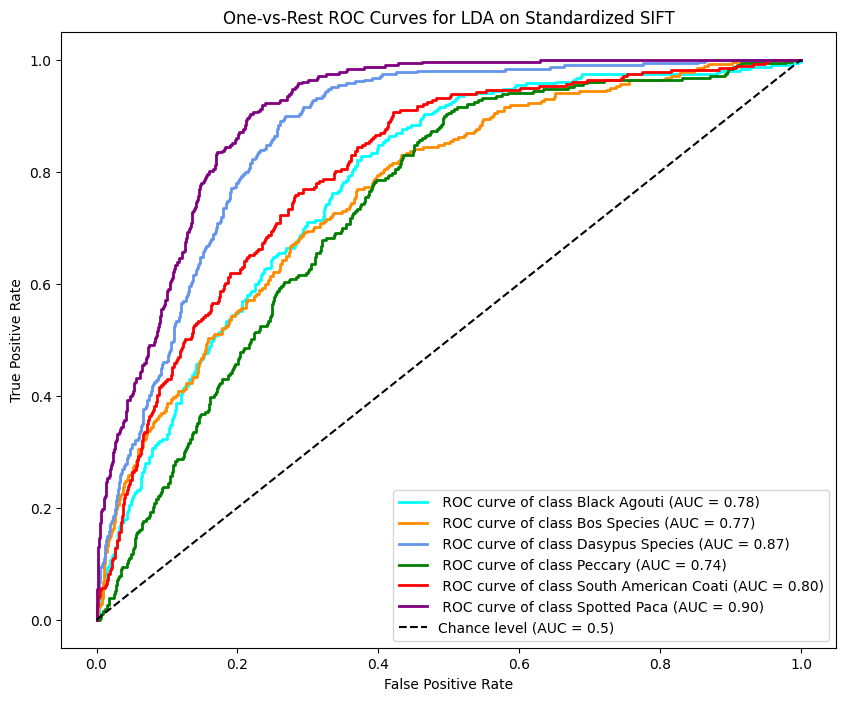

In [ ]:
import matplotlib.pyplot as plt

from sklearn.metrics import RocCurveDisplay

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,8))

colors = ['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple']
for i, label in enumerate(best_model.classes_):
  class_of_interest = label
  class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]

  kwargs = {'lw':2}
  display = RocCurveDisplay.from_predictions(
      y_onehot_train[:, class_id],
      y_scores[:, class_id],
      name=f' ROC curve of class {class_of_interest}',
      ax=ax,
      color=colors[i],
      plot_chance_level=bool(i==5),
      **kwargs
  )
  _ = display.ax_.set(
      xlabel="False Positive Rate",
      ylabel="True Positive Rate",
      title="One-vs-Rest ROC Curves for LDA on Standardized SIFT",
  )